In [44]:
from core.gradient_descent import wolfe_conditions_search, point_number_terminate_condition, fixed_step_search
%load_ext autoreload
%autoreload 2

from core.high_order_optimization import *
from core.optimizer_evaluator import *
from core.utils import *
from core.visualizer import *
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
f1 = lambda x: np.exp(x[0])
f2 = lambda x: np.sin(x[0])
f3 = lambda x: np.exp(-(x[0] + 1))
fs = [f1, f2, f3]

df1 = lambda x: np.array([np.exp(x[0])])
df2 = lambda x: np.array([np.cos(x[0])])
df3 = lambda x: np.array([-np.exp(-(x[0] + 1))])
dfs = [df1, df2, df3]

x0 = np.array([10])

termination = lambda f, points: len(points) > 20

p1 = gauss_newton(fs, dfs, x0, termination)
p2 = gauss_newton_with_approx_grad(fs, x0, termination)

print(f"symbolic grad argmin = {p1[-1]}, approx grad argmin = {p2[-1]}")

symbolic grad argmin = [-0.30823297], approx grad argmin = [-0.3083785]


# Вычисление $\nabla^2 f$: Аналитически, численно

In [46]:
q = QuadraticForm(np.array([
    [10, 2],
    [2, 2]
                  ]))

In [47]:
x = np.array([3, 4])
q.gradient_function()(x)

array([76, 28])

In [48]:
symmetric_gradient_computer(q)(x)

array([76., 28.])

In [49]:
q.hessian_function()(x)

array([[20,  4],
       [ 4,  4]])

In [50]:
symmetric_hessian_computer(q)(x)

array([[20.00000165,  3.99985822],
       [ 3.99985822,  3.99992928]])

In [163]:
def evaluate_quasi_newton_method(get_approximator, get_initial_approximator):
    print("—————— 2 Dimensions ——————")

    roi = SearchRegion2d((-2, 2), (-2, 2))
    visualize_function_3d(q, roi)

    qg = q.gradient_function()
    visualize_optimizing_process(q, roi, np.array(newton_optimize(
        q, qg, get_approximator(q, qg), np.array([1.5, -1.]), wolfe_conditions_search(0.1, 0.9), point_number_terminate_condition(10), get_initial_approximator(q, qg)
    )), 0)

    print("—————— Many Dimensions Rosenbrock ——————")
    from scipy.optimize import rosen, rosen_der

    for n in [2, 10, 50, 100]:
        f = rosen
        rg = rosen_der
        bfgs_points = newton_optimize(f, rg, get_approximator(f, rg),
                                      random_normalized_vector(n),  # Or just zero?
                                      wolfe_conditions_search(0.1, 0.9),
                                      # fibonacci_search(30),
                                      # fixed_step_search(1),
                                      precision_termination_condition,
                                      get_initial_approximator(f, rg)
                                      )
        print(f"Iterations until convergence for n={n}: {len(bfgs_points)}")


    print("—————— Many Dimensions && complicated ——————")

    for n in [2, 10, 50, 100]:
        form = generate_positive_definite_quadratic_form(n, 10, random_orthonormal_basis)
        multipiled = lambda x: form(x) * np.exp(sum(c**2 for c in x))
        mg = symmetric_gradient_computer(multipiled)
        bfgs_points = newton_optimize(multipiled, mg, get_approximator(multipiled, mg), random_normalized_vector(form.n),
                                      wolfe_conditions_search(0.1, 0.9),
                                      # fibonacci_search(30),
                                      # fixed_step_search(1),
                                      precision_termination_condition,
                                      get_initial_approximator(multipiled, mg)
                                      )
        print(f"Iterations until convergence for n={n}: {len(bfgs_points)}")



    print("—————— Many Dimensions ——————")

    for n in [10, 100, 1000, 2000]:
        form = generate_positive_definite_quadratic_form(n, 1000, random_orthonormal_basis)
        fg = form.gradient_function()
        bfgs_points = newton_optimize(form, fg, get_approximator(form, fg), random_normalized_vector(form.n),
                                      wolfe_conditions_search(0.1, 0.9),
                                      # fibonacci_search(30),
                                      precision_termination_condition, get_initial_approximator(form, fg))
        print(f"Iterations until convergence for n={n}: {len(bfgs_points)}")

# Метод Ньютона

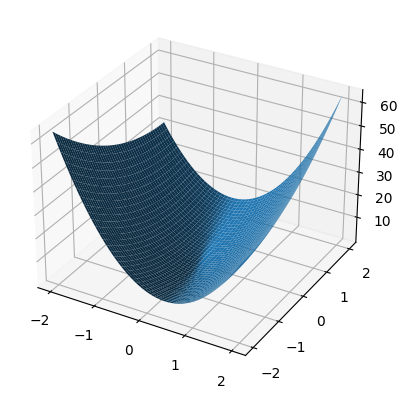

In [51]:
roi = SearchRegion2d((-2, 2), (-2, 2))
visualize_function_3d(q, roi)

—————— 2 Dimensions ——————
[newton_optimize] Computed initial approximation
Best value found: x* = [-1.30923418e-09  8.72822784e-10] with f(x*) = 1.4093662825922414e-17
—————— Many Dimensions Rosenbrock ——————
[newton_optimize] Computed initial approximation
Iterations until convergence for n=2: 11
[newton_optimize] Computed initial approximation


KeyboardInterrupt: 

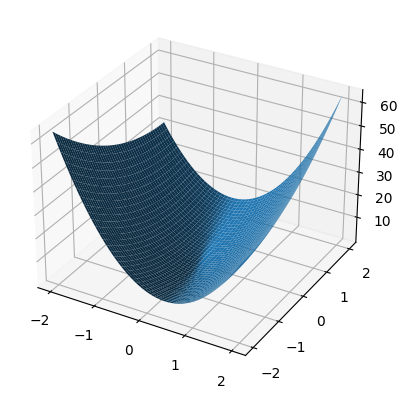

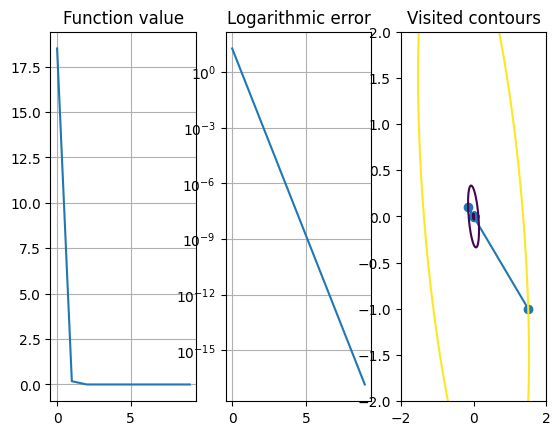

In [165]:
evaluate_quasi_newton_method(lambda f, g: GivenNewtonDirectionApproximator(lambda x: np.linalg.inv(f.hessian_function()(x))) if False and isinstance(f, QuadraticForm) else GivenNewtonDirectionApproximator.numerically_computing(f, g), lambda f, g: none_approximation)

Достаточно ≈11 итераций для матрицы со сколь угодно большим числом обусловленности

In [55]:
form = generate_positive_definite_quadratic_form(100, 1000, random_orthonormal_basis)

In [56]:
points = newton_optimize(form, form.gradient_function(), GivenNewtonDirectionApproximator(lambda x: np.linalg.inv(form.hessian_function()(x))), random_normalized_vector(form.n), wolfe_conditions_search(0.1, 0.9),
                         precision_termination_condition)

Step length:  1.0985000000000003
Step length:  1.0985000000000003
Step length:  1.0985000000000003
Step length:  1.0985000000000003
Step length:  1.0985000000000003
Step length:  1.0985000000000003
Step length:  1.0985000000000003
Step length:  1.0985000000000003
Step length:  1.0985000000000003
Step length:  1.0985000000000003


In [57]:
len(points)

11

In [58]:
[form(p) for p in points]

[229.22110914382083,
 2.223960506190536,
 0.02157742082118648,
 0.00020934953116234515,
 2.0311614887198215e-06,
 1.9706836553931625e-08,
 1.9120065495537745e-10,
 1.8550765545407904e-12,
 1.7998416501292135e-14,
 1.7462513649965688e-16,
 1.6942567306037471e-18]

# BFGS

—————— 2 Dimensions ——————
[newton_optimize] Computed initial approximation
Best value found: x* = [-9.53545419e-09  8.52754320e-08] with f(x*) = 1.220048757809216e-14
—————— Many Dimensions Rosenbrock ——————
[newton_optimize] Computed initial approximation
Iterations until convergence for n=2: 13
[newton_optimize] Computed initial approximation
Iterations until convergence for n=10: 54
[newton_optimize] Computed initial approximation


AssertionError: 

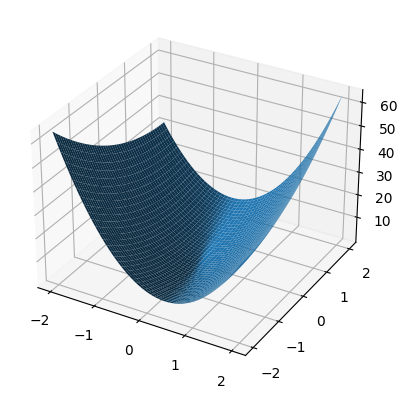

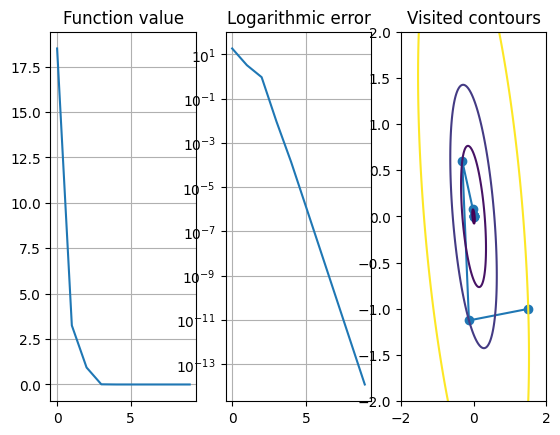

In [154]:
# visualize_optimizing_process(q, roi, np.array(newton_optimize(
#     q, q.gradient_function(), BFGSNewtonDirectionApproximator(),
#     np.array([1.5, -1.]), wolfe_conditions_search(0.1, 0.9), point_number_terminate_condition(10),
#     eye_initial_approximation
# )), 0);

evaluate_quasi_newton_method(lambda f: BFGSNewtonDirectionApproximator(), lambda f: eye_initial_approximation)

# LBFGS

None

—————— 2 Dimensions ——————
[newton_optimize] Computed initial approximation
Best value found: x* = [-0.0078125 -0.0703125] with f(x*) = 0.0126953125
—————— Many Dimensions Rosenbrock ——————
[newton_optimize] Computed initial approximation
Iterations until convergence for n=2: 4063
[newton_optimize] Computed initial approximation
Iterations until convergence for n=10: 6783
[newton_optimize] Computed initial approximation
Iterations until convergence for n=50: 12660
[newton_optimize] Computed initial approximation
Iterations until convergence for n=100: 19731
—————— Many Dimensions && complicated ——————
[newton_optimize] Computed initial approximation
Iterations until convergence for n=2: 38
[newton_optimize] Computed initial approximation
Iterations until convergence for n=10: 33
[newton_optimize] Computed initial approximation
Iterations until convergence for n=50: 35


C:\Users\Vova\AppData\Local\Temp\ipykernel_13576\1245789696.py:31: RuntimeWarning: overflow encountered in exp
  multipiled = lambda x: form(x) * np.exp(sum(c**2 for c in x))


[newton_optimize] Computed initial approximation
Iterations until convergence for n=100: 36
—————— Many Dimensions ——————
[newton_optimize] Computed initial approximation
Iterations until convergence for n=10: 2606
[newton_optimize] Computed initial approximation
Iterations until convergence for n=100: 2661
[newton_optimize] Computed initial approximation


KeyboardInterrupt: 

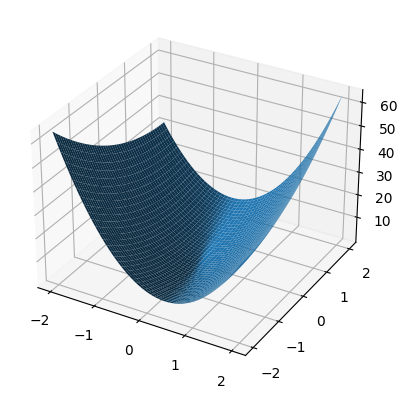

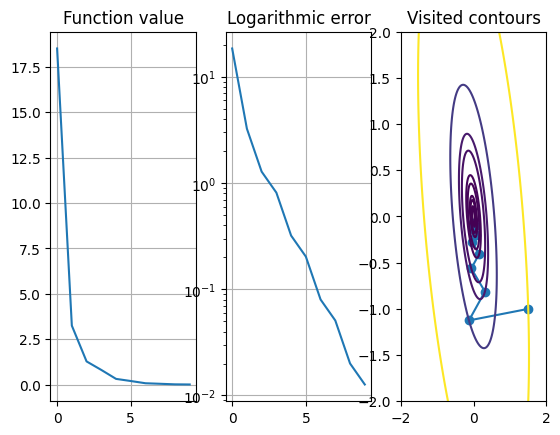

In [155]:
evaluate_quasi_newton_method(lambda f: GivenNewtonDirectionApproximator(lambda x: None), lambda f: none_approximation)

m = 0

—————— 2 Dimensions ——————
[newton_optimize] Computed initial approximation
Best value found: x* = [ 3.90219439e-08 -2.99232287e-08] with f(x*) = 1.2347270099277023e-14
—————— Many Dimensions Rosenbrock ——————
[newton_optimize] Computed initial approximation


AssertionError: 

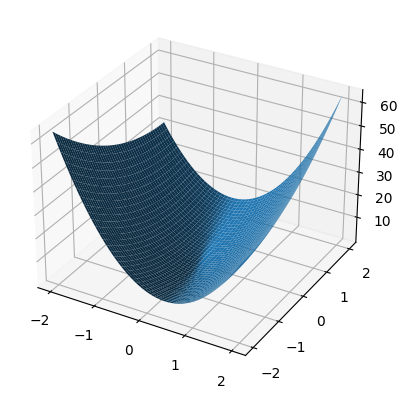

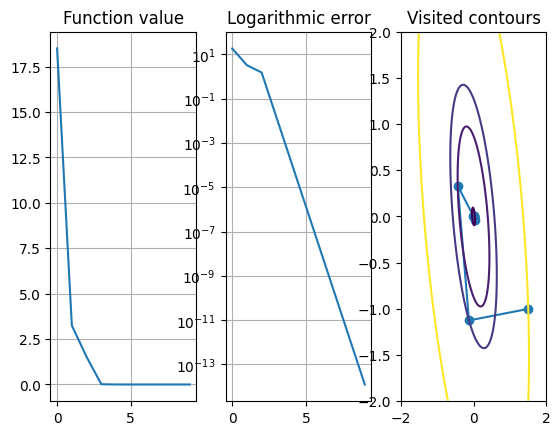

In [156]:
evaluate_quasi_newton_method(lambda f: LBFGSNewtonDirectionApproximator(3), lambda f: none_approximation)

—————— 2 Dimensions ——————
[newton_optimize] Computed initial approximation
Best value found: x* = [ 3.90219439e-08 -2.99232286e-08] with f(x*) = 1.2347270099276946e-14
—————— Many Dimensions Rosenbrock ——————
[newton_optimize] Computed initial approximation
Iterations until convergence for n=2: 14
[newton_optimize] Computed initial approximation
Iterations until convergence for n=10: 57
[newton_optimize] Computed initial approximation
Iterations until convergence for n=50: 1048
[newton_optimize] Computed initial approximation
Iterations until convergence for n=100: 2101
—————— Many Dimensions && complicated ——————
[newton_optimize] Computed initial approximation
Iterations until convergence for n=2: 10
[newton_optimize] Computed initial approximation
Iterations until convergence for n=10: 17
[newton_optimize] Computed initial approximation


C:\Users\Vova\AppData\Local\Temp\ipykernel_13576\1245789696.py:31: RuntimeWarning: overflow encountered in exp
  multipiled = lambda x: form(x) * np.exp(sum(c**2 for c in x))


Iterations until convergence for n=50: 81
[newton_optimize] Computed initial approximation
Iterations until convergence for n=100: 40
—————— Many Dimensions ——————
[newton_optimize] Computed initial approximation
Iterations until convergence for n=10: 18
[newton_optimize] Computed initial approximation
Iterations until convergence for n=100: 159
[newton_optimize] Computed initial approximation
Iterations until convergence for n=1000: 178
[newton_optimize] Computed initial approximation
Iterations until convergence for n=2000: 243


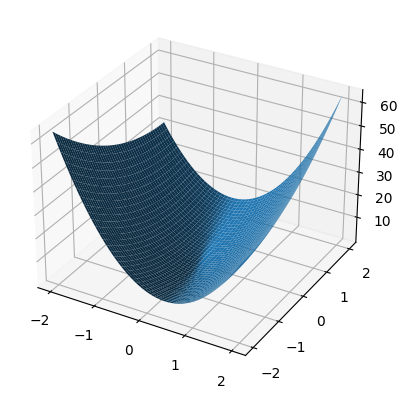

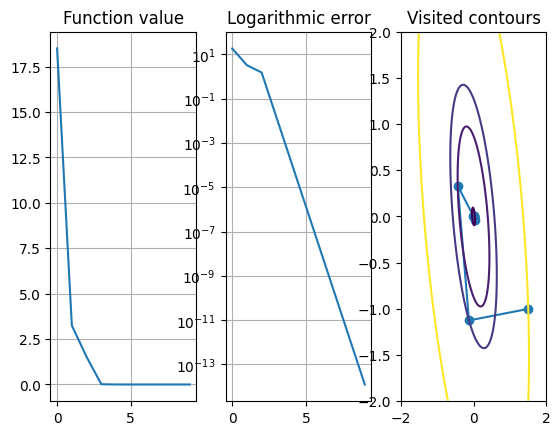

In [158]:
evaluate_quasi_newton_method(lambda f: LBFGSNewtonDirectionApproximator(30), lambda f: none_approximation)

In [108]:
for n in [10, 50, 100, 200, 500, 1000]:
    form = generate_positive_definite_quadratic_form(n, 10, random_orthonormal_basis)
    bfgs_points = newton_optimize(form, form.gradient_function(), BFGSNewtonDirectionApproximator(), random_normalized_vector(form.n), wolfe_conditions_search(0.1, 0.9),
                precision_termination_condition, eye_initial_approximation)
    print(f"Iterations until convergence for n={n}: {len(bfgs_points)}")

[newton_optimize] Computed initial approximation
Iterations until convergence for n=10: 17
[newton_optimize] Computed initial approximation
Iterations until convergence for n=50: 40
[newton_optimize] Computed initial approximation
Iterations until convergence for n=100: 47
[newton_optimize] Computed initial approximation
Iterations until convergence for n=200: 45
[newton_optimize] Computed initial approximation
Iterations until convergence for n=500: 52
[newton_optimize] Computed initial approximation
Iterations until convergence for n=1000: 50


In [109]:
for n in [2, 10, 50, 100, 500]:
    form = generate_positive_definite_quadratic_form(n, 10, random_orthonormal_basis)
    multipiled = lambda x: form(x) * np.exp(sum(c**2 for c in x))
    bfgs_points = newton_optimize(multipiled, symmetric_gradient_computer(multipiled), BFGSNewtonDirectionApproximator(), random_normalized_vector(form.n),
                                  wolfe_conditions_search(0.1, 0.9),
                                  # fibonacci_search(30),
                                  # fixed_step_search(1),
                                  precision_termination_condition,
                                  eye_initial_approximation
                                  )
    print(f"Iterations until convergence for n={n}: {len(bfgs_points)}")

[newton_optimize] Computed initial approximation
Iterations until convergence for n=2: 10
[newton_optimize] Computed initial approximation
Iterations until convergence for n=10: 19
[newton_optimize] Computed initial approximation


C:\Users\Vova\AppData\Local\Temp\ipykernel_13576\2483080757.py:3: RuntimeWarning: overflow encountered in exp
  multipiled = lambda x: form(x) * np.exp(sum(c**2 for c in x))


Iterations until convergence for n=50: 44
[newton_optimize] Computed initial approximation
Iterations until convergence for n=100: 50
[newton_optimize] Computed initial approximation


KeyboardInterrupt: 

In [ ]:
for n in [10, 50, 100, 200, 500, 1000]:
    form = generate_positive_definite_quadratic_form(n, 1000, random_orthonormal_basis)
    bfgs_points = newton_optimize(form, form.gradient_function(), LBFGSNewtonDirectionApproximator(5), random_normalized_vector(form.n), wolfe_conditions_search(0.1, 0.9),
                                  precision_termination_condition, none_approximation)
    print(f"Iterations until convergence for n={n}: {len(bfgs_points)}")

In [97]:
for n in [2, 10, 50, 100, 500]:
    form = generate_positive_definite_quadratic_form(n, 10, random_orthonormal_basis)
    multipiled = lambda x: form(x) * np.exp(sum(c**2 for c in x))
    bfgs_points = newton_optimize(multipiled, symmetric_gradient_computer(multipiled), LBFGSNewtonDirectionApproximator(3), random_normalized_vector(form.n),
                                  # wolfe_conditions_search(0.1, 0.9),
                                  fibonacci_search(30),
                                  # fixed_step_search(1),
                                  precision_termination_condition)
    print(f"Iterations until convergence for n={n}: {len(bfgs_points)}")

[newton_optimize] Computed initial approximation
Iterations until convergence for n=2: 9
[newton_optimize] Computed initial approximation
Iterations until convergence for n=10: 36
[newton_optimize] Computed initial approximation


C:\Users\Vova\AppData\Local\Temp\ipykernel_13576\2580497526.py:3: RuntimeWarning: overflow encountered in exp
  multipiled = lambda x: form(x) * np.exp(sum(c**2 for c in x))


Iterations until convergence for n=50: 42
[newton_optimize] Computed initial approximation
Iterations until convergence for n=100: 58
[newton_optimize] Computed initial approximation
Iterations until convergence for n=500: 58
